Loaded HSI: (1096, 715, 102) min/max: 0.0 1.0
Train cube: (876, 715, 102)  Test cube: (220, 715, 102)
Total extracted patches (before subsampling): 36575
Subsampled to 3000 patches.
Train patches (raw): (3000, 31, 27, 27)
Padded train patches: (3000, 32, 32, 32)

=== Training started ===

Epoch 1/80 | Loss=0.003174 | Val PSNR=7.282 dB | Val SSIM=0.7539 | Epoch time=67.63s | Inference time=35.72s
Epoch 2/80 | Loss=0.001187 | Epoch time=67.93s
Epoch 3/80 | Loss=0.000676 | Epoch time=68.24s
Epoch 4/80 | Loss=0.000501 | Epoch time=68.25s
Epoch 5/80 | Loss=0.000395 | Epoch time=68.14s
Epoch 6/80 | Loss=0.000341 | Epoch time=68.06s
Epoch 7/80 | Loss=0.000330 | Epoch time=68.14s
Epoch 8/80 | Loss=0.000299 | Epoch time=68.18s
Epoch 9/80 | Loss=0.000269 | Epoch time=68.10s
Epoch 10/80 | Loss=0.000260 | Val PSNR=36.617 dB | Val SSIM=0.9541 | Epoch time=68.06s | Inference time=35.54s
Epoch 11/80 | Loss=0.000256 | Epoch time=68.17s
Epoch 12/80 | Loss=0.000248 | Epoch time=68.24s
Epoch 13/80 | Loss

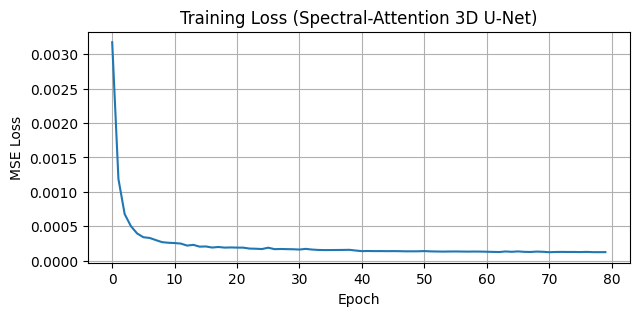

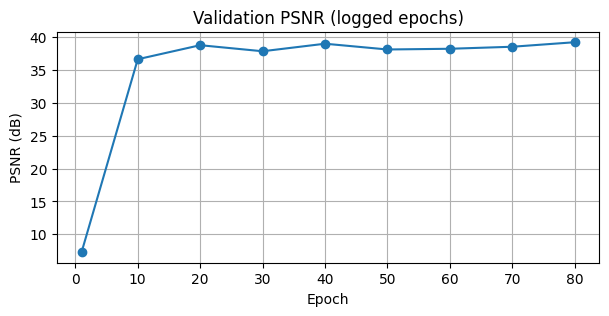

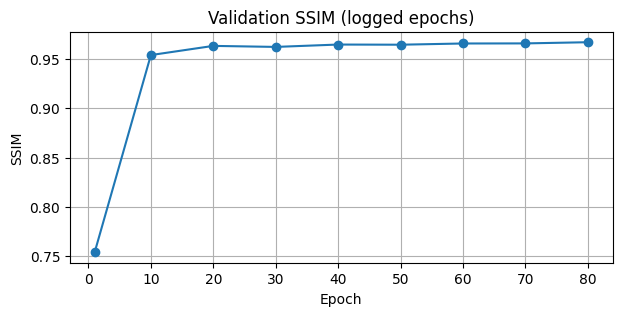


Running final full-cube inference on test split...
Final full-cube inference time: 35.33 s

--- TEST RESULTS (Spectral-Attention 3D U-Net) ---
NOISY  PSNR : 28.38 dB
NOISY  SSIM : 0.7263
DENOISED PSNR : 39.20 dB
DENOISED SSIM : 0.9671
Detected regions: noisy=45, denoised=62, clean=63


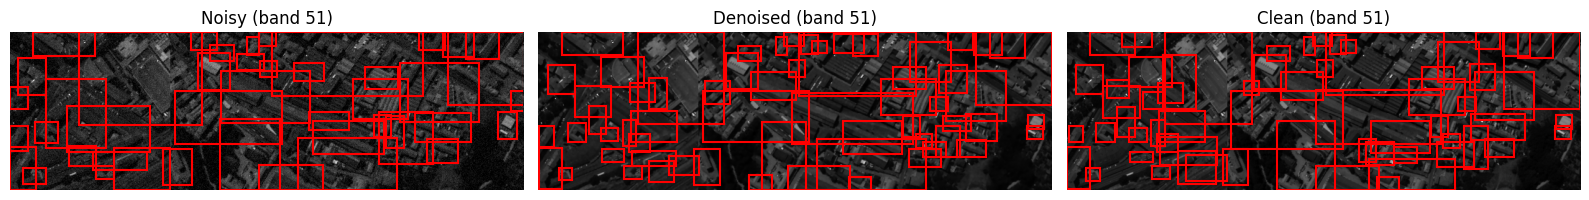


Baseline noisy PSNR = 28.38 dB, SSIM = 0.7263
Final denoised PSNR  = 39.20 dB, SSIM = 0.9671
Total buildings (center band): noisy=45, denoised=62, clean=63
Training log saved to: /content/paviau_saunet_training_log.csv


In [ ]:
# ============================================
# Spectral-Attention 3D U-Net for PaviaU
# Denoising + Building Detection (Bounding Boxes)
# Logs: Loss, PSNR, SSIM, Epoch Time, Inference Time
# ============================================

import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import matplotlib.patches as patches
import time
import csv
import os

# ----------------------------
# Utilities: padding helpers
# ----------------------------
def pad_to_multiple(patch, mult_h=1, mult_w=1, mult_b=1):
    """
    Reflect-pad a 3D cube (H,W,B) so each dim is divisible by (mult_h, mult_w, mult_b).
    Returns padded_cube, pads_tuple.
    """
    H, W, B = patch.shape
    pad_h = (mult_h - (H % mult_h)) % mult_h
    pad_w = (mult_w - (W % mult_w)) % mult_w
    pad_b = (mult_b - (B % mult_b)) % mult_b

    pad_before_h = pad_h // 2
    pad_after_h = pad_h - pad_before_h
    pad_before_w = pad_w // 2
    pad_after_w = pad_w - pad_before_w
    pad_before_b = pad_b // 2
    pad_after_b = pad_b - pad_before_b

    padded = np.pad(
        patch,
        ((pad_before_h, pad_after_h),
         (pad_before_w, pad_after_w),
         (pad_before_b, pad_after_b)),
        mode='reflect'
    )
    pad_slices = (pad_before_h, pad_after_h,
                  pad_before_w, pad_after_w,
                  pad_before_b, pad_after_b)
    return padded, pad_slices

def unpad_from_slices(patch_padded, pad_slices):
    a, b, c, d, e, f = pad_slices
    H, W, B = patch_padded.shape
    h0, h1 = a, H - b
    w0, w1 = c, W - d
    b0, b1 = e, B - f
    return patch_padded[h0:h1, w0:w1, b0:b1]

# ----------------------------
# Load & noise helpers
# ----------------------------
def load_hsi_npy(path):
    """
    Load PaviaU-like .npy cube, normalize to [0,1].
    Expected shape: (H, W, B) = (1096, 715, 102) for PaviaU.
    """
    hsi = np.load(path)
    if hsi.ndim != 3:
        raise ValueError(f"Expected 3D cube, got {hsi.shape}")
    hsi = hsi.astype(np.float32)
    hsi = (hsi - hsi.min()) / (hsi.max() - hsi.min() + 1e-12)
    print("Loaded HSI:", hsi.shape, "min/max:", hsi.min(), hsi.max())
    return hsi

def add_noise(hsi, sigma=0.19607843, seed=None):
    """
    Add Gaussian noise (normalized).
    sigma=0.19607843 ≈ 50/255.
    """
    if seed is not None:
        np.random.seed(seed)
    noise = np.random.normal(0, sigma, hsi.shape).astype(np.float32)
    noisy = np.clip(hsi + noise, 0, 1)
    return noisy

# ----------------------------
# Spectral Attention Blocks
# ----------------------------
class SEBlock3D(nn.Module):
    """
    3D Squeeze-and-Excitation block.
    Learns channel-wise feature/spectral attention.
    """
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)  # (B,C,1,1,1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.avg_pool(x).view(b, c)        # (B,C)
        y = self.fc(y).view(b, c, 1, 1, 1)     # (B,C,1,1,1)
        return x * y

class ConvBlock3D(nn.Module):
    """
    3D Conv block + BatchNorm + ReLU + SEBlock (spectral attention).
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.se = SEBlock3D(out_ch, reduction=8)

    def forward(self, x):
        x = self.conv(x)
        x = self.se(x)
        return x

class SpectralAttentionUNet3D(nn.Module):
    def __init__(self, in_ch=1, base_ch=32, depth=3):
        super().__init__()
        self.depth = depth

        # Encoder
        self.enc_blocks = nn.ModuleList()
        prev = in_ch
        for d in range(depth):
            out = base_ch * (2 ** d)
            self.enc_blocks.append(ConvBlock3D(prev, out))
            prev = out

        # Bottleneck
        self.bottleneck = ConvBlock3D(prev, prev * 2)
        prev = prev * 2

        # Decoder
        self.up_convs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        for d in reversed(range(depth)):
            out = base_ch * (2 ** d)
            self.up_convs.append(nn.ConvTranspose3d(prev, out, kernel_size=2, stride=2))
            self.dec_blocks.append(ConvBlock3D(out + out, out))  # concat with skip
            prev = out

        self.final_conv = nn.Conv3d(base_ch, in_ch, kernel_size=1)
        self.pool = nn.MaxPool3d(2, 2)

    def forward(self, x):
        enc_feats = []
        cur = x
        for enc in self.enc_blocks:
            cur = enc(cur)
            enc_feats.append(cur)
            cur = self.pool(cur)

        cur = self.bottleneck(cur)

        for up, dec, enc_feat in zip(self.up_convs, self.dec_blocks, reversed(enc_feats)):
            cur = up(cur)
            # center crop skip if mismatch due to padding
            if enc_feat.shape[2:] != cur.shape[2:]:
                dh = enc_feat.shape[2] - cur.shape[2]
                dw = enc_feat.shape[3] - cur.shape[3]
                db = enc_feat.shape[4] - cur.shape[4]
                enc_feat = enc_feat[:, :, dh//2:dh//2+cur.shape[2],
                                         dw//2:dw//2+cur.shape[3],
                                         db//2:db//2+cur.shape[4]]
            cur = torch.cat([cur, enc_feat], dim=1)
            cur = dec(cur)
        return self.final_conv(cur)

# ----------------------------
# Patch extraction
# ----------------------------
def extract_patches_3d(clean, noisy, patch_size=(27,27,31), stride=(9,9,15), max_patches=3000):
    """
    Extract overlapping 3D patches and return (clean_patches, noisy_patches).
    Patches are shaped (N, D, H, W).
    """
    ph, pw, pb = patch_size
    sh, sw, sb = stride
    H, W, B = clean.shape
    clean_patches = []
    noisy_patches = []

    for h in range(0, H - ph + 1, sh):
        for w in range(0, W - pw + 1, sw):
            for b in range(0, B - pb + 1, sb):
                c_patch = clean[h:h+ph, w:w+pw, b:b+pb]
                n_patch = noisy[h:h+ph, w:w+pw, b:b+pb]
                # reorder to (D,H,W)
                clean_patches.append(c_patch.transpose(2,0,1))
                noisy_patches.append(n_patch.transpose(2,0,1))

    total = len(clean_patches)
    print(f"Total extracted patches (before subsampling): {total}")
    if total == 0:
        raise ValueError("No patches extracted: check patch_size/stride vs cube shape.")

    if total > max_patches:
        idx = np.random.choice(total, max_patches, replace=False)
        clean_patches = [clean_patches[i] for i in idx]
        noisy_patches = [noisy_patches[i] for i in idx]
        print(f"Subsampled to {max_patches} patches.")

    clean_patches = np.stack(clean_patches, axis=0)  # (N,D,H,W)
    noisy_patches = np.stack(noisy_patches, axis=0)
    return clean_patches, noisy_patches

# ----------------------------
# Sliding-starts helper (edge coverage)
# ----------------------------
def sliding_starts(length, patch, stride):
    starts = list(range(0, length - patch + 1, stride))
    if len(starts) == 0:
        starts = [0]
    last = starts[-1]
    end_pos = length - patch
    if last != end_pos:
        starts.append(end_pos)
    return starts

# ----------------------------
# Sliding-window inference
# ----------------------------
def denoise_cube_unet(model, noisy_cube, patch_size=(27,27,31), stride=(12,12,20), depth=3, device=None):
    ph, pw, pb = patch_size
    sh, sw, sb = stride
    H, W, B = noisy_cube.shape

    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    model.eval()

    out_cube = np.zeros_like(noisy_cube, dtype=np.float32)
    weight_cube = np.zeros_like(noisy_cube, dtype=np.float32)

    mult = 2 ** depth
    h_starts = sliding_starts(H, ph, sh)
    w_starts = sliding_starts(W, pw, sw)
    b_starts = sliding_starts(B, pb, sb)

    with torch.no_grad():
        for h in h_starts:
            for w in w_starts:
                for b in b_starts:
                    patch = noisy_cube[h:h+ph, w:w+pw, b:b+pb]  # (ph,pw,pb)
                    padded, pads = pad_to_multiple(patch, mult, mult, mult)
                    padded = padded.transpose(2,0,1)  # (D,H,W)
                    x = torch.tensor(padded, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                    out = model(x).squeeze(0).squeeze(0).cpu().numpy()  # (D,H,W)
                    out = out.transpose(1,2,0)  # (H,W,B)
                    out_unp = unpad_from_slices(out, pads)

                    out_cube[h:h+ph, w:w+pw, b:b+pb] += out_unp
                    weight_cube[h:h+ph, w:w+pw, b:b+pb] += 1.0

    denoised = noisy_cube.copy()
    mask = weight_cube > 0
    denoised[mask] = out_cube[mask] / weight_cube[mask]
    return denoised

# ----------------------------
# Building detection (bounding boxes)
# ----------------------------
def detect_buildings_and_bboxes(band_image, min_area=50):
    """
    Simple building-like region detection:
    Otsu threshold + connected components + area filter.
    Returns list of (minr, minc, maxr, maxc, area).
    """
    thresh = threshold_otsu(band_image)
    mask = band_image >= thresh
    lab = label(mask)
    props = regionprops(lab)
    boxes = []
    for p in props:
        if p.area >= min_area:
            minr, minc, maxr, maxc = p.bbox
            boxes.append((minr, minc, maxr, maxc, p.area))
    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    return boxes

def plot_band_with_bboxes(ax, img_band, boxes, title):
    ax.imshow(img_band, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    for (minr, minc, maxr, maxc, area) in boxes:
        rect = patches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            linewidth=1.5,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

# ----------------------------
# Full-cube evaluation + building marking
# ----------------------------
def evaluate_and_mark_buildings(denoised, noisy, clean, band=None, min_area=150):
    H, W, B = clean.shape
    if band is None:
        band = B // 2

    # ---- noisy vs clean metrics ----
    noisy_psnr = np.mean([
        peak_signal_noise_ratio(clean[:,:,b], noisy[:,:,b], data_range=1.0)
        for b in range(B)
    ])
    try:
        noisy_ssim = np.mean([
            structural_similarity(clean[:,:,b], noisy[:,:,b], data_range=1.0)
            for b in range(B)
        ])
    except:
        noisy_ssim = 0.0

    # ---- denoised vs clean metrics ----
    den_psnr = np.mean([
        peak_signal_noise_ratio(clean[:,:,b], denoised[:,:,b], data_range=1.0)
        for b in range(B)
    ])
    try:
        den_ssim = np.mean([
            structural_similarity(clean[:,:,b], denoised[:,:,b], data_range=1.0)
            for b in range(B)
        ])
    except:
        den_ssim = 0.0

    print("\n--- TEST RESULTS (Spectral-Attention 3D U-Net) ---")
    print(f"NOISY  PSNR : {noisy_psnr:.2f} dB")
    print(f"NOISY  SSIM : {noisy_ssim:.4f}")
    print(f"DENOISED PSNR : {den_psnr:.2f} dB")
    print(f"DENOISED SSIM : {den_ssim:.4f}")

    # ---- Building region detection ----
    noisy_band    = noisy[:,:,band]
    denoised_band = denoised[:,:,band]
    clean_band    = clean[:,:,band]

    boxes_noisy    = detect_buildings_and_bboxes(noisy_band,    min_area=min_area)
    boxes_denoised = detect_buildings_and_bboxes(denoised_band, min_area=min_area)
    boxes_clean    = detect_buildings_and_bboxes(clean_band,    min_area=min_area)

    print(f"Detected regions: noisy={len(boxes_noisy)}, denoised={len(boxes_denoised)}, clean={len(boxes_clean)}")

    fig, axs = plt.subplots(1, 3, figsize=(16,5))
    plot_band_with_bboxes(axs[0], noisy_band,    boxes_noisy,    f"Noisy (band {band})")
    plot_band_with_bboxes(axs[1], denoised_band, boxes_denoised, f"Denoised (band {band})")
    plot_band_with_bboxes(axs[2], clean_band,    boxes_clean,    f"Clean (band {band})")
    plt.tight_layout()
    plt.show()

    return noisy_psnr, noisy_ssim, den_psnr, den_ssim, boxes_noisy, boxes_denoised, boxes_clean


# ----------------------------
# Training with logging:
# Loss, PSNR, SSIM, Epoch Time, Inference Time
# ----------------------------
def train_net(model,
              clean_patches,
              noisy_patches,
              epochs=50,
              lr=1e-4,
              batch_size=4,
              device=None,
              clean_val_cube=None,
              noisy_val_cube=None,
              patch_size=(27,27,31),
              infer_stride=(12,12,20),
              depth=3,
              log_csv_path="training_log.csv"):
    """
    clean_patches, noisy_patches: numpy arrays (N, D, H, W) already padded.
    clean_val_cube, noisy_val_cube: full cubes for validation/inference metrics.
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)

    # convert to tensors: (N,1,D,H,W)
    clean_t = torch.tensor(clean_patches, dtype=torch.float32).unsqueeze(1)
    noisy_t = torch.tensor(noisy_patches, dtype=torch.float32).unsqueeze(1)

    dataset = TensorDataset(noisy_t, clean_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)
    loss_fn = nn.MSELoss()

    # prepare CSV logging
    header = ["epoch", "train_loss", "val_psnr", "val_ssim", "epoch_time_sec", "inference_time_sec"]
    if log_csv_path is not None:
        with open(log_csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header)

    loss_list = []
    psnr_list = []
    ssim_list = []
    epoch_times = []
    infer_times = []

    print("\n=== Training started ===\n")
    start_total = time.time()

    for epoch in range(1, epochs+1):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0

        for noisy_batch, clean_batch in loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)

            optimizer.zero_grad()
            out = model(noisy_batch)
            loss = loss_fn(out, clean_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * noisy_batch.size(0)

        epoch_loss = running_loss / len(loader.dataset)
        loss_list.append(epoch_loss)
        scheduler.step()

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        # validation metrics every 10 epochs (and at epoch 1)
        val_psnr = None
        val_ssim = None
        inf_time = None

        if clean_val_cube is not None and noisy_val_cube is not None and (epoch % 10 == 0 or epoch == 1):
            inf_start = time.time()
            den_val = denoise_cube_unet(
                model,
                noisy_val_cube,
                patch_size=patch_size,
                stride=infer_stride,
                depth=depth,
                device=device
            )
            inf_time = time.time() - inf_start
            infer_times.append(inf_time)

            B = clean_val_cube.shape[2]
            psnrs = []
            ssims = []
            for b in range(B):
                psnrs.append(
                    peak_signal_noise_ratio(clean_val_cube[:,:,b], den_val[:,:,b], data_range=1.0)
                )
                try:
                    ssims.append(
                        structural_similarity(clean_val_cube[:,:,b], den_val[:,:,b], data_range=1.0)
                    )
                except:
                    ssims.append(0.0)
            val_psnr = float(np.mean(psnrs))
            val_ssim = float(np.mean(ssims))
            psnr_list.append(val_psnr)
            ssim_list.append(val_ssim)

            print(f"Epoch {epoch}/{epochs} | "
                  f"Loss={epoch_loss:.6f} | "
                  f"Val PSNR={val_psnr:.3f} dB | "
                  f"Val SSIM={val_ssim:.4f} | "
                  f"Epoch time={epoch_time:.2f}s | "
                  f"Inference time={inf_time:.2f}s")

        else:
            print(f"Epoch {epoch}/{epochs} | Loss={epoch_loss:.6f} | Epoch time={epoch_time:.2f}s")

        # write CSV log
        if log_csv_path is not None:
            with open(log_csv_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch,
                    epoch_loss,
                    val_psnr if val_psnr is not None else "",
                    val_ssim if val_ssim is not None else "",
                    epoch_time,
                    inf_time if inf_time is not None else ""
                ])

    total_time = time.time() - start_total
    print(f"\n=== Training finished in {total_time/60:.2f} minutes ===")

    # Plot loss curve
    plt.figure(figsize=(7,3))
    plt.plot(loss_list)
    plt.title("Training Loss (Spectral-Attention 3D U-Net)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

    # Plot PSNR / SSIM vs logged epochs (approx: first + every 10)
    if len(psnr_list) > 0:
        logged_epochs = [1] + list(range(10, epochs+1, 10))
        logged_epochs = logged_epochs[:len(psnr_list)]

        plt.figure(figsize=(7,3))
        plt.plot(logged_epochs, psnr_list, marker='o')
        plt.title("Validation PSNR (logged epochs)")
        plt.xlabel("Epoch")
        plt.ylabel("PSNR (dB)")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(7,3))
        plt.plot(logged_epochs, ssim_list, marker='o')
        plt.title("Validation SSIM (logged epochs)")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.grid(True)
        plt.show()

    return model

# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # ---- user parameters ----
    npy_path       = "/content/drive/MyDrive/pavia.npy"   # <-- change to your file
    sigma          = 0.0392         # ≈ 10/255
    patch_size     = (27,27,31)
    extract_stride = (9,9,15)
    infer_stride   = (12,12,20)
    max_patches    = 3000
    epochs         = 80
    batch_size     = 4
    base_ch        = 32
    depth          = 3
    lr             = 1e-4
    min_area       = 150
    device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    log_csv        = "paviau_saunet_training_log.csv"

    # ---- load and noise ----
    hsi   = load_hsi_npy(npy_path)
    noisy = add_noise(hsi, sigma=sigma, seed=42)

    # ---- 80/20 spatial split along rows ----
    H = hsi.shape[0]
    split = int(0.8 * H)
    clean_train = hsi[:split, :, :]
    noisy_train = noisy[:split, :, :]
    clean_test  = hsi[split:, :, :]
    noisy_test  = noisy[split:, :, :]
    print("Train cube:", clean_train.shape, " Test cube:", clean_test.shape)

    # ---- extract patches from training cube ----
    clean_patches, noisy_patches = extract_patches_3d(
        clean_train, noisy_train,
        patch_size=patch_size,
        stride=extract_stride,
        max_patches=max_patches
    )
    print("Train patches (raw):", clean_patches.shape)  # (N, D, H, W)

    # ---- pad training patches so U-Net pooling (2^depth) works ----
    mult = 2 ** depth
    padded_clean_list = []
    padded_noisy_list = []

    for i in range(clean_patches.shape[0]):
        # (D,H,W) -> (H,W,B=D)
        c_hw_b = clean_patches[i].transpose(1,2,0)
        p_c, _ = pad_to_multiple(c_hw_b, mult_h=mult, mult_w=mult, mult_b=mult)
        padded_clean_list.append(p_c.transpose(2,0,1))  # back to (D,H,W)

        n_hw_b = noisy_patches[i].transpose(1,2,0)
        p_n, _ = pad_to_multiple(n_hw_b, mult_h=mult, mult_w=mult, mult_b=mult)
        padded_noisy_list.append(p_n.transpose(2,0,1))

    padded_clean = np.stack(padded_clean_list, axis=0)
    padded_noisy = np.stack(padded_noisy_list, axis=0)
    print("Padded train patches:", padded_clean.shape)

    # ---- build model ----
    model = SpectralAttentionUNet3D(in_ch=1, base_ch=base_ch, depth=depth)

    # ---- train with logging ----
    model = train_net(
        model,
        padded_clean,
        padded_noisy,
        epochs=epochs,
        lr=lr,
        batch_size=batch_size,
        device=device,
        clean_val_cube=clean_test,
        noisy_val_cube=noisy_test,
        patch_size=patch_size,
        infer_stride=infer_stride,
        depth=depth,
        log_csv_path=log_csv
    )

    # ---- final full-cube denoising ----
    print("\nRunning final full-cube inference on test split...")
    t0 = time.time()
    denoised_test = denoise_cube_unet(
        model,
        noisy_test,
        patch_size=patch_size,
        stride=infer_stride,
        depth=depth,
        device=device
    )
    final_infer_time = time.time() - t0
    print(f"Final full-cube inference time: {final_infer_time:.2f} s")

    # ---- evaluate & mark buildings with bounding boxes ----
    noisy_psnr, noisy_ssim, psnr_val, ssim_val, boxes_noisy, boxes_denoised, boxes_clean = evaluate_and_mark_buildings(
        denoised_test, noisy_test, clean_test,
        band=None,        # center spectral band
        min_area=min_area
    )

    print(f"\nBaseline noisy PSNR = {noisy_psnr:.2f} dB, SSIM = {noisy_ssim:.4f}")
print(f"Final denoised PSNR  = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")
print(f"Total buildings (center band): noisy={len(boxes_noisy)}, denoised={len(boxes_denoised)}, clean={len(boxes_clean)}")
print(f"Training log saved to: {os.path.abspath(log_csv)}")
